https://medium.com/@melek.messoussi/bounding-boxes-gone-rogue-why-vlms-are-failing-at-creating-bounding-boxes-around-structured-text-03d19371101e

In [1]:
# !python -m pip list

In [2]:
import transformers

/home/yang/miniconda3/envs/object_dect/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# !pip install git+https://github.com/huggingface/transformers
# !pip install qwen-vl-utils
# !pip install qwen_agent

In [4]:
# !apt-get install fonts-noto-cjk

In [5]:
import os
from PIL import Image, ImageDraw, ImageFont
import requests
from io import BytesIO
from bs4 import BeautifulSoup, Tag
from pathlib import Path
import re

In [6]:
from IPython.display import display

In [8]:
image_path = "https://www.google.com/imgres?q=cat%20photo&imgurl=https%3A%2F%2Fplus.unsplash.com%2Fpremium_photo-1667030474693-6d0632f97029%3Fixlib%3Drb-4.1.0%26ixid%3DM3wxMjA3fDB8MHxzZWFyY2h8MXx8Y2F0fGVufDB8fDB8fHww%26fm%3Djpg%26q%3D60%26w%3D3000&imgrefurl=https%3A%2F%2Funsplash.com%2Fs%2Fphotos%2Fcat&docid=2F6tSb78YteoPM&tbnid=AOW-svy-hGXHjM&vet=12ahUKEwjp4JCmiqaQAxU6K0QIHTTMB3IQM3oECCAQAA..i&w=3000&h=4500&hcb=2&ved=2ahUKEwjp4JCmiqaQAxU6K0QIHTTMB3IQM3oECCAQAA"
image_path = "/home/yang/MyRepos/object_detection/images/dog2.jpg"
if image_path.startswith("http"):
    response = requests.get(image_path)
    image = Image.open(BytesIO(response.content))
else:
    image = Image.open(image_path)

# image.show()
print(image.width)
print(image.height)

331
500


In [9]:
# !pip uninstall -y transformers
# !pip install git+https://github.com/huggingface/transformers accelerate
# !pip install qwen-vl-utils[decord]==0.0.8

In [10]:
# !pip install torch==2.4

In [11]:
import torch
from transformers import Qwen3VLForConditionalGeneration, AutoTokenizer, AutoProcessor
model_path = "Qwen/Qwen3-VL-4B-Instruct"
model = Qwen3VLForConditionalGeneration.from_pretrained(model_path, dtype=torch.bfloat16,device_map="auto")
# model = Qwen3VLForConditionalGeneration.from_pretrained(model_path, dtype=torch.bfloat16, attn_implementation="flash_attention_2",device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)

Loading checkpoint shards: 100%|██████████████████| 2/2 [00:02<00:00,  1.34s/it]


In [12]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {
                "type": "text", 
                "text": """
                Please describe this image. Extract the objects in the image and generate bounding box x_min, y_min, x_max, y_max in the format with following keys: description, label, bbox_2d}
                """
            },
        ],
    }
]

# Preparation for inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
print(inputs)
inputs = inputs.to(model.device)
print(inputs)

{'input_ids': tensor([[151644,    872,    198,  ..., 151644,  77091,    198]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]]), 'pixel_values': tensor([[ 0.4196,  0.4196,  0.4275,  ...,  0.5922,  0.5922,  0.5922],
        [ 0.4667,  0.4667,  0.4667,  ...,  0.6235,  0.6235,  0.6235],
        [ 0.4667,  0.4667,  0.4745,  ...,  0.6078,  0.6157,  0.6157],
        ...,
        [-0.1529, -0.1608, -0.1608,  ..., -0.3255, -0.3176, -0.3176],
        [-0.2078, -0.2078, -0.2078,  ..., -0.3333, -0.3412, -0.3490],
        [-0.1765, -0.2000, -0.2235,  ..., -0.4196, -0.4275, -0.4353]]), 'image_grid_thw': tensor([[  1,  86, 128]])}
{'input_ids': tensor([[151644,    872,    198,  ..., 151644,  77091,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[ 0.4196,  0.4196,  0.4275,  ...,  0.5922,  0.5922,  0.5922],
        [ 0.4667,  0.4667,  0.4667,  ...,  0.6235,  0.6235,  0.6235],
        [ 0.4667,  0.4667,  0.4745,  ..

In [13]:
# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
print(generated_ids)
# The generated_ids includes the inputs.input_ids prompt. Need to remove the prompt to get output
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

tensor([[151644,    872,    198,  ...,    532,  73594, 151645]],
       device='cuda:0')
['```json\n{\n  "description": "A woman and a golden retriever are sitting on a sandy beach at sunset, giving each other a high-five. The woman is smiling and wearing a plaid shirt, while the dog is wearing a harness. The ocean is visible in the background with gentle waves. The sun is setting, casting a warm glow over the scene.",\n  "label": "woman",\n  "bbox_2d": [451, 382, 731, 793]\n}\n```']


# Object Detection Head

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bbox(image_path, bboxs, labels, new_size = (1000, 600)):
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")

    # Resize the image
    image = image.resize(new_size)

    fig, ax = plt.subplots(1)
    ax.imshow(image)

    for box, label in zip(bboxs, labels):
        x_min, y_min, x_max, y_max = box
        width, height = x_max - x_min, y_max - y_min
        rect = patches.Rectangle((x_min, y_min),
            width,
            height,
            linewidth = 2,
            edgecolor = 'r',
            facecolor = 'none'
        )
        ax.add_patch(rect)
        plt.text(
            x_min, 
            y_min, 
            f"{label}", 
            color='white', 
            fontsize=12,
            bbox = dict(facecolor='red', alpha=0.5)
        )

    plt.axis('off')
    plt.show()

In [15]:
image_path = "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg"
image_path = "/home/yang/MyRepos/object_detection/images/cat4.jpg"

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": image_path,
            },
            {
                "type": "text", 
                "text": """
                Please describe this image. Extract the objects in the image and generate bounding box x_min, y_min, x_max, y_max in the format with as follows:
                {
                    "description": "",
                    "objects": 
                    [
                        {
                            "label": "",
                            "bbox_2d": [x_min, y_min, x_max, y_max]
                        },
                        {
                            "label": "",
                            "bbox_2d": [x_min, y_min, x_max, y_max]
                        },
                        ...
                    ]
                }
                """
            },
        ],
    }
]

# Preparation for inference
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=512)
print(generated_ids)
# The generated_ids includes the inputs.input_ids prompt. Need to remove the prompt to get output
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)

tensor([[151644,    872,    198, 151652, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655, 151655,
         151655, 151655, 151653,    198,    394,   5209,   7512,    419,   2168,
             13,  22826,    279,   6171,    304,    279,   2168,    323,   6923,
          30618,   3745,    856,   7260,     11,    379,   7260,     11,    856,
           6345,     11,    379,   6345,    304,    279,   3561,    448,    438,
          11017,    510,    

{
    "description": "A small tabby kitten is resting on a windowsill, looking outward through a screen. The kitten has striped fur and is positioned near the edge of the window, with its paws resting on the sill and its body slightly curled. The background shows a dark mesh screen and a white window frame.",
    "objects": [
        {
            "label": "kitten",
            "bbox_2d": [102, 168, 916, 838]
        },
        {
            "label": "window sill",
            "bbox_2d": [0, 624, 1000, 999]
        },
        {
            "label": "window screen",
            "bbox_2d": [0, 0, 832, 712]
        },
        {
            "label": "window frame",
            "bbox_2d": [778, 0, 1000, 702]
        }
    ]
}
[{'label': 'kitten', 'bbox_2d': [102, 168, 916, 838]}, {'label': 'window sill', 'bbox_2d': [0, 624, 1000, 999]}, {'label': 'window screen', 'bbox_2d': [0, 0, 832, 712]}, {'label': 'window frame', 'bbox_2d': [778, 0, 1000, 702]}]
['kitten', 'window sill', 'window screen

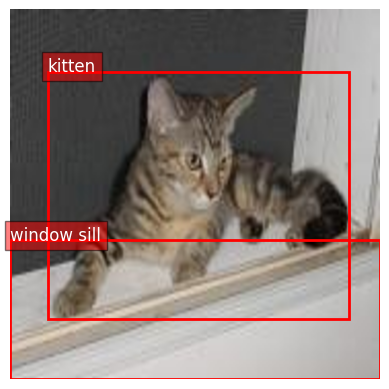

In [16]:
import json

print(output_text[0])
output_json = json.loads(output_text[0])
objects = output_json['objects']
print(objects)

bboxs = []
labels = []

for object_item in objects:
    label = object_item['label']
    bbox = object_item['bbox_2d']

    labels.append(label)
    bboxs.append(bbox)

print(labels)
print(bboxs)

draw_bbox(
    image_path,
    bboxs[:2],
    labels[:2],
    new_size = (1000, 1000)
)